In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import torch
from sklearn.metrics import root_mean_squared_error, r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
import shap
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
trn = pd.read_csv("../data/processed/trn.feat.csv")
tst_08SC = pd.read_csv("../data/processed/tst.08SC.feat.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.feat.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.feat.csv")

trn_y, trn_X = trn["Solubility"], trn.drop(["Solubility", "Name", "SMILES"], axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)

In [3]:
tune_space = {
    "learning_rate": hp.choice("learning_rate", [0.1, 0.01, 0.001]),
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400]),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
}

In [4]:
def tune_obj(space):
    kf = KFold(n_splits=3, shuffle=True)
    rmse = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X.iloc[trn_idx], trn_X.iloc[val_idx]
        ty, vy = trn_y.iloc[trn_idx], trn_y.iloc[val_idx]

        booster = lgb.LGBMRegressor(
            learning_rate=space["learning_rate"],
            n_estimators=space["n_estimators"],
            n_jobs=10,
            reg_alpha=space["reg_alpha"],
            reg_lambda=space["reg_lambda"],
        )
        booster.fit(tX, ty)

        pred = booster.predict(vX)
        rmse.append(root_mean_squared_error(vy, pred))

    return {"loss": np.mean(rmse), 'status': STATUS_OK}

In [ ]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

In [9]:
best_params

{'learning_rate': 0,
 'n_estimators': 1,
 'reg_alpha': 0.9183516844450554,
 'reg_lambda': 0.5589029406916396}

In [3]:
kf = KFold(n_splits=10, shuffle=True)

pred_19t1, pred_19t2, pred_08t = [], [], []
feat_importance = []
boosters = []

for trn_idx, val_idx in kf.split(trn_X):
    tX, vX = trn_X.loc[trn_idx], trn_X.loc[val_idx]
    ty, vy = trn_y[trn_idx], trn_y[val_idx]
    booster = lgb.LGBMRegressor(
        learning_rate=0.01,
        n_estimators=500,
        verbosity=0
    )
    booster.fit(tX, ty, eval_set=[(vX, vy)])

    pred_validation = booster.predict(vX)
    print(f"rmse, {root_mean_squared_error(vy, pred_validation):.3f}, r2, {r2_score(vy, pred_validation):.3f}")

    pred_19t1.append(booster.predict(tst1_19SC_X))
    pred_19t2.append(booster.predict(tst2_19SC_X))
    pred_08t.append(booster.predict(tst_08SC_X))
    boosters.append(booster)

rmse, 0.483, r2, 0.947
rmse, 0.592, r2, 0.905
rmse, 0.549, r2, 0.905
rmse, 0.523, r2, 0.925
rmse, 0.602, r2, 0.917
rmse, 0.476, r2, 0.938
rmse, 0.515, r2, 0.939
rmse, 0.576, r2, 0.921
rmse, 0.490, r2, 0.940
rmse, 0.726, r2, 0.890


In [4]:
tst1_19SC_pred = np.mean(pred_19t1, axis=0)
tst2_19SC_pred = np.mean(pred_19t2, axis=0)
tst_08SC_pred = np.mean(pred_08t, axis=0)
performance = {
    "2019SC TST1 (RMSE)": root_mean_squared_error(tst1_19SC_y.values, tst1_19SC_pred),
    "2019SC TST2 (RMSE)": root_mean_squared_error(tst2_19SC_y.values, tst2_19SC_pred),
    "2008SC TST  (RMSE)": root_mean_squared_error(tst_08SC_y.values, tst_08SC_pred),
    "2019SC TST1 (R^2)": r2_score(tst1_19SC_y.values, tst1_19SC_pred),
    "2019SC TST2 (R^2)": r2_score(tst2_19SC_y.values, tst2_19SC_pred),
    "2008SC TST  (R^2)": r2_score(tst_08SC_y.values, tst_08SC_pred),
}
performance

{'2019SC TST1 (RMSE)': 0.8160465848974389,
 '2019SC TST2 (RMSE)': 1.388000136535583,
 '2008SC TST  (RMSE)': 0.7612508262483404,
 '2019SC TST1 (R^2)': 0.4515402982283455,
 '2019SC TST2 (R^2)': 0.5211089568759596,
 '2008SC TST  (R^2)': 0.6853306035514906}

Text(0.5, 1.0, '08SC (LightGBM)   RMSE: 0.761, $R^2$: 0.685')

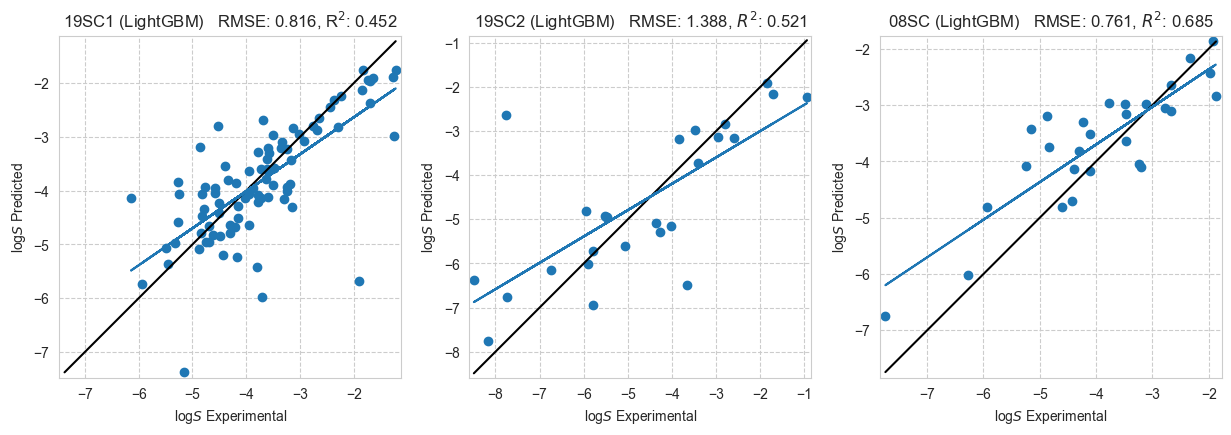

In [6]:
import matplotlib.pyplot as plt


def subplot(x, y, ax):
    ax.scatter(x, y)
    ax.set_xlim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    ax.set_ylim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))
    ax.grid(which='major', linestyle='--')
    ax.plot([min(min(x), min(y)), max(max(x), max(y))], [min(min(x), min(y)), max(max(x), max(y))], 'k')
    a, b = np.polyfit(x, y, 1)
    y_fit = a * x + b
    ax.plot(x, y_fit)
    ax.set_xlabel("log$S$ Experimental")
    ax.set_ylabel("log$S$ Predicted")


model_name = "LightGBM"

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(5 * 3, 5))

subplot(tst1_19SC_y.values, tst1_19SC_pred, ax1)
subplot(tst2_19SC_y.values, tst2_19SC_pred, ax2)
subplot(tst_08SC_y.values, tst_08SC_pred, ax3)

ax1.set_title(f"19SC1 ({model_name})   "
              f"RMSE: {performance['2019SC TST1 (RMSE)']:.3f}, "
              f"R$^2$: {performance['2019SC TST1 (R^2)']:.3f}")
ax2.set_title(f"19SC2 ({model_name})   "
              f"RMSE: {performance['2019SC TST2 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST2 (R^2)']:.3f}")
ax3.set_title(f"08SC ({model_name})   "
              f"RMSE: {performance['2008SC TST  (RMSE)']:.3f}, "
              f"$R^2$: {performance['2008SC TST  (R^2)']:.3f}")

Feature importance according to tree split.

In [24]:
feat_importance = pd.concat([pd.DataFrame(booster.feature_importances_) for booster in boosters], axis=1)
feat_importance.index = trn_X.columns
feat_importance_mean = feat_importance.mean(axis=1)

MW                   2.3
Rdkit2DBalabanJ     16.1
Rdkit2DBertzCT      24.8
Rdkit2DChi0          1.1
Rdkit2DChi0n         1.8
                   ...  
CDKWTPT-5            0.1
CDKWPATH             0.0
CDKWPOL              0.0
CDKXLogP           529.4
CDKZagreb            0.0
Length: 4480, dtype: float64

In [29]:
# zero-importance features are not be included
# i.e. those features that have not been used in any split conditions.
min_v, max_v = feat_importance.min().min(), feat_importance.max().max()
feat_importance_sort = ((feat_importance - min_v) / (max_v - min_v)).loc[
    feat_importance_mean.sort_values(ascending=False).index]  # normalization
feat_importance_sort.to_csv("../data/feats.importance.lightgbm.csv")
feat_importance_sort

,0,0,0,0,0,0,0,0,0,0
CDKXLogP,0.777080,0.855573,0.839874,0.864992,0.783359,0.883830,1.000000,0.797488,0.722135,0.786499
Rdkit2DMolLogP,0.651491,0.660911,0.629513,0.645212,0.664050,0.638932,0.616954,0.529042,0.638932,0.533752
CDKJPLogP,0.478807,0.403454,0.436421,0.437991,0.433281,0.353218,0.428571,0.492936,0.452119,0.579278
MordredRNCG,0.317111,0.359498,0.431711,0.263736,0.315542,0.332810,0.346939,0.414443,0.408163,0.381476
MordredFilterItLogS,0.265306,0.337520,0.356358,0.334380,0.318681,0.332810,0.324961,0.389325,0.343799,0.370487
...,...,...,...,...,...,...,...,...,...,...
Circular135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Permutation feature importance using test sets for supervised.

In [30]:
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0)
tst_y = pd.concat([tst_08SC_y, tst1_19SC_y, tst2_19SC_y], axis=0)

pis = []
for booster in boosters:
    pi = permutation_importance(booster, tst_X, tst_y, n_jobs=-1)
    pis.append(pi)

In [32]:
perm_importance = pd.concat([pd.DataFrame(pis[i].importances_mean) for i in range(len(pis))], axis=1)
perm_importance.index = trn_X.columns
perm_importance_mean = perm_importance.mean(axis=1)
min_v, max_v = perm_importance.min().min(), perm_importance.max().max()
perm_importance_sort = ((perm_importance - min_v) / (max_v - min_v)).loc[
    perm_importance_mean.sort_values(ascending=False).index]  # normalization
perm_importance_sort.to_csv("../data/feats.importance.lightgbm.csv")
perm_importance_sort

,0,0,0,0,0,0,0,0,0,0
Rdkit2DMolLogP,0.861024,1.000000,0.828441,0.764312,0.830986,0.714536,0.880457,0.654176,0.742433,0.498816
CDKJPLogP,0.896943,0.643773,0.466582,0.697810,0.742271,0.774042,0.835387,0.718146,0.647142,0.794137
MordredFilterItLogS,0.382682,0.435571,0.348184,0.419544,0.421238,0.339920,0.389878,0.334904,0.309004,0.198480
MordredZMIC1,0.109473,0.144799,0.162911,0.249576,0.094253,0.184811,0.116500,0.214219,0.140406,0.129357
CDKXLogP,0.203196,0.127968,0.097964,0.120724,0.167289,0.109690,0.277309,0.130771,0.095687,0.003850
...,...,...,...,...,...,...,...,...,...,...
MordredGATS3d,0.094018,0.089375,0.031035,0.074648,0.086720,0.083895,0.085398,0.083733,0.083889,0.087025
MordredGGI4,0.086067,0.078521,0.052006,0.091547,0.071264,0.081484,0.084420,0.084604,0.079878,0.086462
Rdkit2DSMR_VSA10,0.087017,0.090565,0.093706,0.092729,0.083585,0.069994,0.072658,0.088190,0.066007,0.051397
Rdkit2DPEOE_VSA6,0.093419,0.081304,0.069126,0.085715,0.088510,0.064671,0.057430,0.075688,0.084821,0.087012


SHAP feature importance. (Tree Explainer)

In [33]:
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0)
tst_y = pd.concat([tst_08SC_y, tst1_19SC_y, tst2_19SC_y], axis=0)

sis = []
for booster in boosters:
    explainer = shap.TreeExplainer(booster)
    si = explainer.shap_values(tst_X, tst_y)
    sis.append(si)

In [36]:
shap_importance = pd.concat([pd.DataFrame(np.abs(sis[i]).mean(axis=0)) for i in range(len(sis))], axis=1)
shap_importance.index = trn_X.columns
shap_importance_mean = shap_importance.mean(axis=1)
min_v, max_v = shap_importance.min().min(), shap_importance.max().max()
shap_importance_sort = ((shap_importance - min_v) / (max_v - min_v)).loc[
    shap_importance_mean.sort_values(ascending=False).index]  # normalization
shap_importance_sort.to_csv("../data/feats.importance.lightgbm.csv")
shap_importance_sort

,0,0,0,0,0,0,0,0,0,0
CDKJPLogP,0.820409,0.772009,0.767202,0.836543,0.893713,0.837256,0.783104,0.883442,0.852550,1.000000
Rdkit2DMolLogP,0.679749,0.682152,0.694426,0.673151,0.640632,0.574128,0.583897,0.611033,0.599884,0.466570
MordredFilterItLogS,0.353522,0.433776,0.413162,0.449879,0.420431,0.408318,0.423273,0.421627,0.375825,0.447644
CDKXLogP,0.240752,0.256439,0.239589,0.219207,0.228166,0.296532,0.293301,0.266193,0.220035,0.211164
MordredpiPC3,0.125056,0.125088,0.076143,0.135207,0.170751,0.143426,0.137895,0.102074,0.151220,0.132982
...,...,...,...,...,...,...,...,...,...,...
Circular135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Circular138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Subsets of features.

In [4]:
feat_importance_sort = pd.read_excel("../data/feature.importance.xlsx", sheet_name="LightGBM (tree-split)", index_col=0)
perm_importance_sort = pd.read_excel("../data/feature.importance.xlsx", sheet_name="LightGBM (permutation)",
                                     index_col=0)
shap_importance_sort = pd.read_excel("../data/feature.importance.xlsx", sheet_name="LightGBM (tree-explainer)",
                                     index_col=0)

In [5]:
feat_importance_mean = feat_importance_sort.mean(axis=1).sort_index()
perm_importance_mean = perm_importance_sort.mean(axis=1).sort_index()
shap_importance_mean = shap_importance_sort.mean(axis=1).sort_index()
importance_rank = (feat_importance_mean + perm_importance_mean + shap_importance_mean).sort_values(
    ascending=False).index
importance_rank

Index(['Rdkit2DMolLogP', 'CDKJPLogP', 'CDKXLogP', 'MordredFilterItLogS',
       'MordredRNCG', 'MordredZMIC1', 'MordredpiPC3', 'CDKBCUTc-1l',
       'CDKATSc3', 'MordredRPCG',
       ...
       'Circular343', 'Circular344', 'Circular345', 'Circular346',
       'Circular347', 'Circular348', 'Circular349', 'Circular35',
       'Circular350', 'Circular958'],
      dtype='object', length=4480)

In [14]:
rmse_dict, r2_dict = {}, {}
tst_X = pd.concat([tst_08SC_X, tst1_19SC_X, tst2_19SC_X], axis=0)
tst_y = pd.concat([tst_08SC_y, tst1_19SC_y, tst2_19SC_y], axis=0)

for n in [5, 10, 15, 20, 30, 40, 60, 80,
          100, 110, 120, 130, 140, 150, 160, 180,
          200, 225, 250, 275, 300, 325, 350, 375, 400, 450, 500, 550,
          600, 650, 700, 750, 800, 850, 900, 950,
          1000, 1500, 2000, 2500, 3000, 3500, 4000]:
    rmse, r2 = [], []
    sub_trn_X = trn_X[importance_rank[:n]]

    for i in range(5):
        for trn_idx, val_idx in KFold(n_splits=5, shuffle=True).split(sub_trn_X):
            tX, vX = sub_trn_X.loc[trn_idx], sub_trn_X.loc[val_idx]
            ty, vy = trn_y[trn_idx], trn_y[val_idx]

            booster = lgb.LGBMRegressor(
                learning_rate=0.01,
                n_estimators=500,
                verbose=0
            )
            booster.fit(tX, ty)

            tst_pred = booster.predict(tst_X[importance_rank[:n]])
            rmse.append(root_mean_squared_error(tst_y.values, tst_pred))
            r2.append(r2_score(tst_y.values, tst_pred))

    rmse_dict[n] = rmse
    r2_dict[n] = r2

In [15]:
rmse = pd.DataFrame(rmse_dict).melt(var_name="n_feats", value_name="rmse")
r2 = pd.DataFrame(r2_dict).melt(var_name="n_feats", value_name="r2")
rmse_mean = pd.DataFrame(rmse_dict).mean()
r2_mean = pd.DataFrame(r2_dict).mean()

Text(140, 0.4000527876077299, '130')

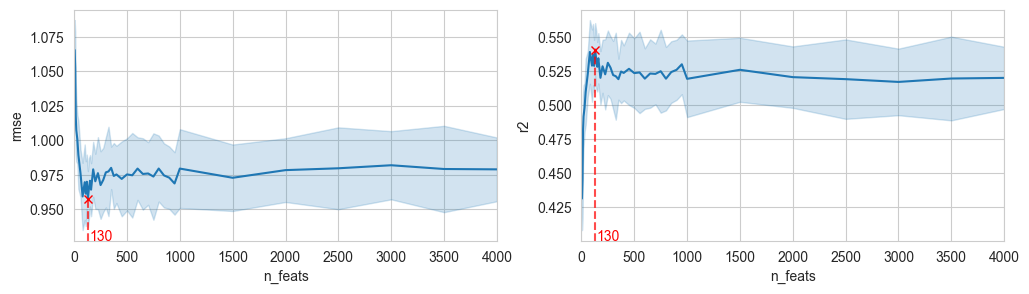

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))

sns.lineplot(rmse, x="n_feats", y="rmse", ax=ax1, errorbar="sd")
ax1.axvline(x=rmse_mean.idxmin(),
            ymin=0,
            ymax=(rmse_mean.min() - ax1.get_ylim()[0]) / (ax1.get_ylim()[1] - ax1.get_ylim()[0]),
            color='red', linestyle='--', alpha=0.7)
ax1.set_xlim(0, rmse["n_feats"].max())
ax1.plot(rmse_mean.idxmin(), rmse_mean.min(), 'rx')
ax1.text(int(rmse_mean.idxmin()) + 10, ax1.get_ylim()[0], f"{rmse_mean.idxmin()}", color='red')

sns.lineplot(r2, x="n_feats", y="r2", ax=ax2, errorbar="sd")
ax2.axvline(x=r2_mean.idxmax(),
            ymin=0,
            ymax=(r2_mean.max() - ax2.get_ylim()[0]) / (ax2.get_ylim()[1] - ax2.get_ylim()[0]),
            color='red', linestyle='--', alpha=0.7)
ax2.set_xlim(0, r2["n_feats"].max())
ax2.plot(r2_mean.idxmax(), r2_mean.max(), 'rx')
ax2.text(int(r2_mean.idxmax()) + 10, ax2.get_ylim()[0], f"{r2_mean.idxmax()}", color='red')

In [18]:
rmse.to_csv("lightgbm.RMSE.csv")
r2.to_csv("lightgbm.R2.csv")